# Test Multi-Kernel Learning on multiple Holdout datasets

### Overall Aim: to find out if combining kenels from the different feature sets improves prediction. 
Assumption: if prediction improves then the kernels must contain non-redundant information.
#### Kernels: DNA_9, AA_4,PC_6, Domains


In [21]:
%reload_ext autoreload
%autoreload 2
import os
import pandas as pd
import pickle
import random
import numpy as np
#import timeit
from itertools import product
#from collections import defaultdict, Counter
from pathlib import Path
#from Bio import SeqIO
import sys
from sklearn.svm import SVC
#from sklearn.model_selection import GridSearchCV, cross_val_score
#from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import make_pipeline
#from sklearn.pipeline import Pipeline
#from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_auc_score

lib_dir = '../mylibs'
if lib_dir not in sys.path:
    sys.path.append(lib_dir)
   
#
#import vhdb as vhdb
from featureset import FeatureSet
from dataset import DataSet

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
%matplotlib inline 

In [2]:
def get_confusion( y_test,y_pred):
    FN=0
    FP=0
    TP=0
    TN=0
    #missed = 0
    for y,yp in zip(y_test,y_pred):
        #print (y_true,yp,yp2,yprob)
        if y == True and yp == False:
            FN += 1
        elif y == False and yp == True:
            FP +=1
        elif y == True and yp == True:
            TP +=1
        else:
            TN +=1
    spec = round(TN/(TN+FP),2) if (TN + TP) else 'NA'
    sens = round(TP/(TP+FN),2) if (TP+FN) else 'NA'
    prec  = round(TP/(TP+FP),2) if (TP+FP) else 'NA'
    res  = { 'Acc':round((TP+TN)/(len(y_test)),2),'Spec':spec, 'Sens':sens,'Prec':prec}
    return res

In [6]:
filein = Path('../inputs/VHDB_25_1_2019.p')
with open(filein, 'rb') as f:
    V_H = pickle.load( f)

In [38]:
def test_kernel_comb (ec,data = [],split = 10):
    mask = ec.ds['trn/tst']=='train'
    y_train = np.asarray(ec.ds[mask]['y'],dtype=int)
    y_test = np.asarray(ec.ds[~mask]['y'],dtype=int)
    for w in [(i/100,j/100,k/100,m/100) for i in range (0,101,split) for j in range (0,101,split)\
                    for k in range (0,101,split ) for m in range (0,101,split) if i+j+k+m== 100]:
                       
        clf1 = SVC(kernel='precomputed',probability=True)
                       
        K_trn = w[0]*ec.fs[0].K_trn + w[1]*ec.fs[1].K_trn + w[2]*ec.fs[2].K_trn + w[3]*ec.fs[3].K_trn
        K_tst = w[0]*ec.fs[0].K_tst + w[1]*ec.fs[1].K_tst + w[2]*ec.fs[2].K_tst + w[3]*ec.fs[3].K_tst
        
        clf1.fit(K_trn, y_train) 
        y_probs= clf1.predict_proba(K_tst)[:,1]
        AUC =round( roc_auc_score(y_test, y_probs),3)
        y_pred = clf1.predict(K_tst)
        n= sum([x > 0 for x in w ])
        results= {'label':ec.label,'holdout':ec.holdout,'dataset':f'{ec.label}_{ec.holdout}',\
                  'AUC': AUC ,'N in training ds':len(y_train), 'n kernels': n ,\
                   ec.fs[0].name:w[0], ec.fs[1].name:w[1],\
                   ec.fs[2].name:w[2], ec.fs[3].name:w[3]
                 }
        results.update(get_confusion(y_test,y_pred))
        data.append(results)
    return data

In [111]:
old_ds =pd.read_csv('datasets4figs/Bacillales_Siphoviridae.csv')
old_ds.head()

,virus,y,refseqs,trn/tst
0,320839,1,['NC_007054'],test
1,320847,1,['NC_007062'],test
2,1273712,1,['NC_021773'],test
3,320843,1,['NC_007058'],test
4,1498220,1,['NC_025460'],test


In [112]:
all_results = []
split = 10 
fs = ['AA_4','PC_6','Domains_0','DNA_9'] #
#test
#fs = ['AA_1','PC_1','Domains_0','DNA_1']


ss = ('Bacillaceae', 'family', 'Firmicutes', 'phylum', 'DNA', 'Siphoviridae')
holdout = ss[-1]
subset = ss [:-1]
#tt_split = 0 because using holdout as test set
ds = DataSet(subset,V_H , tt_split = 0, holdout=holdout) 


Siphoviridae ('Bacillaceae', 'family', 'Firmicutes', 'phylum', 'DNA')
before ani -not_ho pos 86 neg 121
after ani -not_ho pos 83 neg 77
Bacillaceae_Siphoviridae [86, 121, 83, 77]
ho_pos 20 ho_neg 20 not_ho_pos 77 not_ho_neg 77
holdout  Siphoviridae 194
     virus  y      refseqs trn/tst
0  1406784  1  [NC_022766]    test
1  1273741  1  [NC_020477]    test
2    10724  1  [NC_004166]    test
3   345922  1  [NC_007814]    test
4  1273742  1  [NC_020480]    test


In [113]:
# load dataset used in the paper
from ast import literal_eval
old_ds =pd.read_csv('datasets4figs/Bacillales_Siphoviridae.csv')
old_ds.loc[:,'refseqs'] = old_ds.loc[:,'refseqs'].apply(lambda x: literal_eval(x))
ds.ds = old_ds
ds.addFeatureSets(fs)

['NC_007054']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 4 columns):
virus      116 non-null int64
y          116 non-null int64
refseqs    116 non-null object
trn/tst    116 non-null object
dtypes: int64(2), object(2)
memory usage: 3.8+ KB
<class 'list'>


In [118]:
split = 5
all_results = test_kernel_comb(ds,data = [], split= split)
print ('all results', len(all_results))
df = pd.DataFrame(all_results)

all results 1771


Change the number of kernels contributing to the classifier to catagorical for plotting

In [119]:
df['n kernels'] = df['n kernels'].astype('category')
cats = list(df['n kernels'].unique())
df['n kernels'].cat.set_categories(cats, inplace=True)
df.head()

,label,holdout,dataset,AUC,N in training ds,n kernels,AA_4,PC_6,Domains_0,DNA_9,Acc,Spec,Sens,Prec
0,Bacillaceae,Siphoviridae,Bacillaceae_Siphoviridae,0.905,77,1,0.0,0.0,0.00,1.00,0.59,0.95,0.21,0.8
1,Bacillaceae,Siphoviridae,Bacillaceae_Siphoviridae,0.905,77,2,0.0,0.0,0.05,0.95,0.59,0.95,0.21,0.8
2,Bacillaceae,Siphoviridae,Bacillaceae_Siphoviridae,0.905,77,2,0.0,0.0,0.10,0.90,0.59,0.95,0.21,0.8
3,Bacillaceae,Siphoviridae,Bacillaceae_Siphoviridae,0.905,77,2,0.0,0.0,0.15,0.85,0.59,0.95,0.21,0.8
4,Bacillaceae,Siphoviridae,Bacillaceae_Siphoviridae,0.905,77,2,0.0,0.0,0.20,0.80,0.59,0.95,0.21,0.8


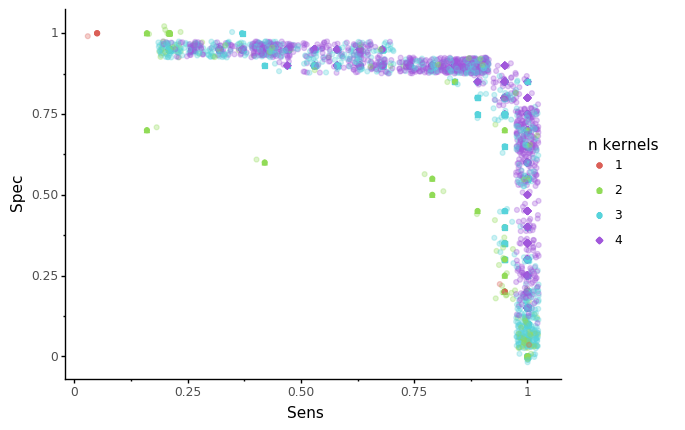

<ggplot: (-9223363268636991309)>

In [120]:
p =(ggplot(data = df,
    mapping =aes(x='Sens',y='Spec', color = 'n kernels'))
     + geom_point(aes (shape='n kernels'))
     + geom_point ()
     + geom_jitter(alpha=0.3,width = 0.025, height = 0.025)
     + theme_classic()
)
p
#p.save ('figure9.png', height=4, width=4,dpi = 500)

Using plotnine to 'jitter ' points as they are all overlapping as ineffect the spec/sens are discrete because the are only 40 viruses in the test split.

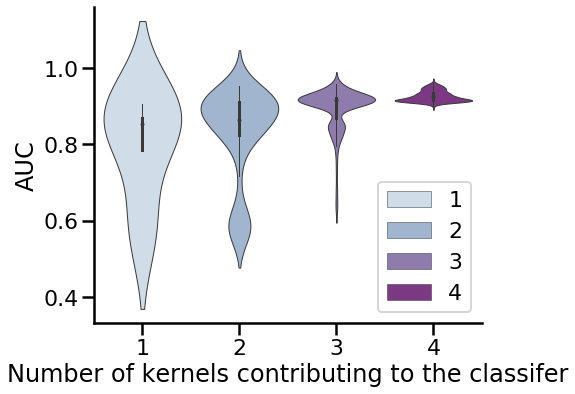

In [121]:
fig,ax= plt.subplots(figsize=(8, 6))
sns.set_context ('poster')
sns.violinplot( x = 'n kernels', y ='AUC', hue = 'n kernels',width =0.8,linewidth =1,dodge = False,
                 data = df,palette = 'BuPu'
              )
#ax.set_title ('Combined kernel classifiers.',fontdict={'size':12})

ax.set_xlabel ('Number of kernels contributing to the classifer')#,fontdict={'size':10})
ax.legend(loc='lower right')
sns.despine()
fig.tight_layout()


In [126]:
df.groupby(['n kernels']).count()['label']

n kernels
1      4
2    114
3    684
4    969
Name: label, dtype: int64

In [128]:
df.groupby(['n kernels']).mean()['AUC']

n kernels
1    0.800000
2    0.828675
3    0.892317
4    0.926062
Name: AUC, dtype: float64